# GP eval metrics

**Goal:** I want the suite of validation plots for the GP, and also to have a way to address whether or not what I have is "good enough".

In [97]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm
import uproot 

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/','../PAG-opt/'] 

from statUtils import getEigenvariations
from plots import draw_SR

from gp import *
#from flows import *
#from bkgPred import *
from make_gp_plots import plot_hist2d
from hh4b_plots.phys_utils import get_lumi

from matplotlib.colors import LogNorm

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
subDir = 'data161718-MAY21_4b_rev_deta_ggf'
modelDir = f'../gp-for-flows/models/{subDir}'

region_tag = "\n4b, rev $\Delta \eta_{HH}$ SR"


In [29]:
# as a _test_ file, load in one of the 2016 guys

In [40]:
yr=18
gp_file = np.load(f'{modelDir}/GPfit_unc_{yr}.npz')

In [6]:
x,y = 124,117

x_cr, y_cr = (x*1.05, y*1.05)
r_cr = 45
nbins = 25

ex = np.linspace(x_cr-r_cr,x_cr+r_cr,nbins+1)
ey = np.linspace(y_cr-r_cr,y_cr+r_cr,nbins+1)

In [7]:
for k in gp_file.keys():
    print(k)

m1m2
bkgd_2d
bkgd
stat_err
norm_bkgd
norm_stat_err
bkgdmodel
uncert
mean
std
n_sig
LL
fitted_len


In [55]:
def plot_hist2d(m1m2,h_2d,ex,ey,zlabel='',cmap='Purples',norm=None,
                symmmetrize=False,lumi=126,region_tag='',
                figName='',rotation=270,labelpad=20):
    
    if symmmetrize:
        h_min, h_max = np.min(h_2d), np.max(h_2d)
        if norm is None:
            # Center around 0
            r = max(abs(h_min),h_max)
            kwargs = {'vmin':-r, 'vmax':r}
        else:
            # Center around 1
            r = max(1/h_min,h_max)
            kwargs = {'vmin':1/r, 'vmax':r}
            
    else:
        kwargs = {}
    
    plt.hist2d(*m1m2.T, [ex,ey], cmap=cmap, weights=h_2d.T.flatten(),norm=norm,**kwargs)

    cbar = plt.colorbar()
    
    xx,yy = draw_SR()
    plt.plot(xx,yy,'hh:darkpink')
    
    plt.xlabel('$m_{H1}$ [GeV]',loc='right')
    plt.ylabel('$m_{H2}$ [GeV]',loc='top')
    
    cbar.set_label(zlabel,rotation=rotation,fontsize=20,y=1,ha='left',labelpad=labelpad)
    
    fig,ax = plt.gcf(), plt.gca()
    pas.makeATLAStag(ax, fig, first_tag=' Internal',
                     second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(get_lumi(str(yr)))+" fb$^{-1}$"+region_tag,
                     ymax=.85,line_spacing=.2,
                     fontsize_title=15,fontsize_label=11)    
    
    if figName:
        plt.savefig(figName,bbox_inches='tight')
    
    plt.show()

In [9]:
m1m2 = gp_file['m1m2']

In [11]:
# Patches can be a nice way to let the text be  more visible
# import matplotlib.patches as mpatches
# args = ((85,135),50,30)
# rect1=mpatches.Rectangle(*args, 
#                         fc = "w",
#                         alpha=.5)
# ax.add_patch(rect1)


# rect2=mpatches.Rectangle(*args, 
#                         fill=None,
#                         ec='k',
#                         linewidth =2)
# ax.add_patch(rect2)

In [19]:
load_cols = [f'm_h1', 'm_h2','ntag','pass_vbf_sel'] 
fname = f'../data/RR/cryptotuples/rev_deta/data_rev_deta_{yr}.root'
#fname = f'../data/RR/NR-UNBLIND-FEB22-1/data{yr}.root'

print(fname)
with uproot.open(fname) as f:

    dfi = f['fullmassplane'].arrays(load_cols,library='pd')

../data/RR/cryptotuples/rev_deta/data_rev_deta_18.root


In [57]:
m_4b = (dfi.ntag>=4) & (~dfi.pass_vbf_sel)
h_obs,xedges,yedges = np.histogram2d(*dfi.loc[m_4b,['m_h1','m_h2']].values.T,[ex,ey])

In [119]:
w_x = widths(xedges)
w_y = widths(yedges)
mids_x = mid(xedges)
mids_y = mid(yedges)

m1m2_ur = np.array(
    list(itertools.product(mids_x + w_x / 2.0, mids_y + w_y / 2.0))
)
m1m2_dr = np.array(
    list(itertools.product(mids_x + w_x / 2.0, mids_y - w_y / 2.0))
)
m1m2_ul = np.array(
    list(itertools.product(mids_x - w_x / 2.0, mids_y + w_y / 2.0))
)
m1m2_dl = np.array(
    list(itertools.product(mids_x - w_x / 2.0, mids_y - w_y / 2.0))
)

blind = (
    (Xhh(*m1m2_ur.T, x, y) > 1.6)
    & (Xhh(*m1m2_dr.T, x, y) > 1.6)
    & (Xhh(*m1m2_ul.T, x, y) > 1.6)
    & (Xhh(*m1m2_dl.T, x, y) > 1.6)
)

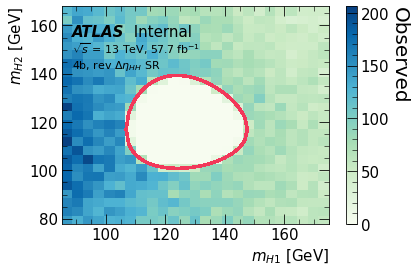

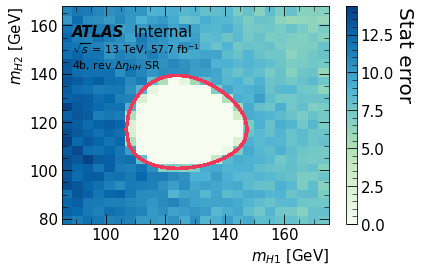

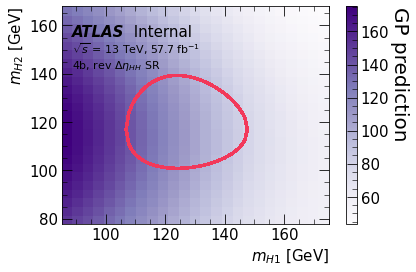

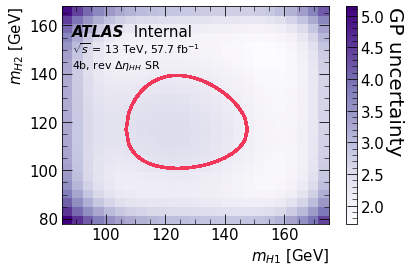

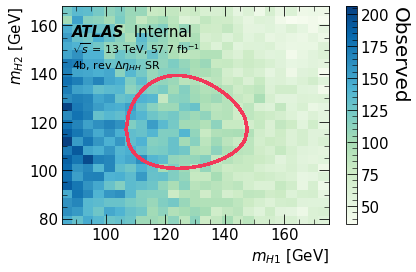

<ipython-input-21-d148975534a0>:19: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.hist2d(*m1m2.T, [ex,ey], cmap=cmap, weights=h_2d.T.flatten(),norm=norm,**kwargs)


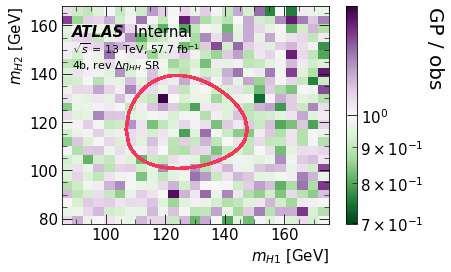

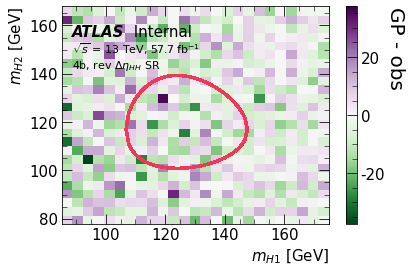

In [43]:
    
lumi = get_lumi(str(yr))

plot_hist2d(m1m2,gp_file['bkgd_2d'],ex,ey,'Observed','GnBu',lumi=lumi,
            region_tag=region_tag,figName='mp_obs_18.jpg')
plot_hist2d(m1m2,gp_file['stat_err'].reshape(25,25),ex,ey,'Stat error','GnBu',
            lumi=lumi,region_tag=region_tag)

plot_hist2d(m1m2,gp_file['bkgdmodel'],ex,ey,'GP prediction',lumi=lumi,
            region_tag=region_tag)
plot_hist2d(m1m2,gp_file['uncert'],ex,ey,'GP uncertainty',lumi=lumi,
            region_tag=region_tag)

# Sanity check
plot_hist2d(m1m2,h_obs,ex,ey,'Observed','GnBu',lumi=lumi,region_tag=region_tag)

# GP non-closures
plot_hist2d(m1m2,gp_file['bkgdmodel']/h_obs,ex,ey,'GP / obs','PRGn_r',norm=LogNorm(),
            symmmetrize=True,lumi=lumi,region_tag=region_tag)

plot_hist2d(m1m2,gp_file['bkgdmodel']-h_obs,ex,ey,'GP - obs','PRGn_r',symmmetrize=True,
            lumi=lumi,region_tag=region_tag)

In [37]:
figDir = f'figures/{subDir}'

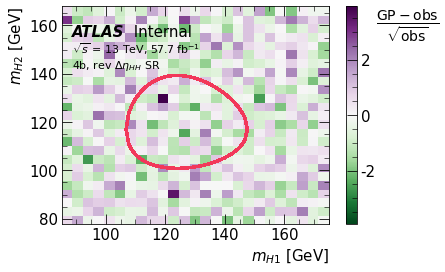

In [56]:
z = (gp_file['bkgdmodel']-h_obs)/np.sqrt(h_obs)

plot_hist2d(m1m2,z,ex,ey,
            r'$\frac{\mathrm{GP - obs}}{\sqrt{\mathrm{obs}}}$',
            'PRGn_r',symmmetrize=True,
            lumi=lumi,region_tag=region_tag,
            figName=f'{figDir}/massplane_pred_minus_obs_over_sqrt_obs_{yr}',
            rotation=0,labelpad=0)

**note:** This is still ok for the shifted SR b/c Xhh fct modifies the resolution for SR points far away from the nominal value.

In [115]:
from make_gp_plots import rainbow_text

In [128]:
def plot_1d_pulls(z,blind,r,nb,xlabel,figName):
    '''
    Goal: Plot a 1d dist that characterizes the non-closure of the GP.
    '''
    z_flat = z.flatten()

    #nb = 12
    # r=(-3,3)

    eps=0.001
    lw = 3

    fig, ax = plt.subplots(1,1,figsize=(5,5))

    ls = []
    lc = ['mediumpurple','hh:darkpink']
    for zi, li, ci in zip([z_flat[blind],z_flat[~blind]],
                          [r'$\neg$ SR','SR'],lc):

        zo  = np.where(zi > r[1], r[1]-eps, zi)
        zou = np.where(zo < r[0], r[0]+eps, zo)

        hi = plt.hist(zou,nb,r,color=ci,label=li,histtype='step',lw=lw)[0]

        mu  = np.mean(zi)
        std = np.std(zi)
        ls.append(f'$\mu$ = {mu: .2f}, $\sigma$ = {std:.2f}')

        #plt.plot([mu]*2,[0,np.max(hi)],ci,lw=lw,ls='dotted')

    plt.legend(fontsize=18)
    plt.xlabel(xlabel,loc='right',fontsize=24)
    plt.ylabel(f'Entries / {(r[1]-r[0])/nb}',loc='top')

    plt.xlim(r)
    _,ymax = plt.ylim()
    plt.ylim(0,1.6*ymax)

    #fig,ax = plt.gcf(), plt.gca()
    pas.makeATLAStag(ax, fig, first_tag=' Internal',
                     second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(get_lumi(str(yr)))+" fb$^{-1}$"+region_tag,
                     ymax=.87,line_spacing=.2,
                     fontsize_title=15,fontsize_label=11)    

    if r[0]==-3:
        rainbow_text(-2.8,1.1*ymax,ls,lc,yoffset=1.0,ax=ax,fontsize=12)
    else:
        rainbow_text(r[0],1.1*ymax,ls,lc,yoffset=1.0,ax=ax,fontsize=12)
        
    plt.savefig(f'{figName}.pdf',bbox_inches='tight')

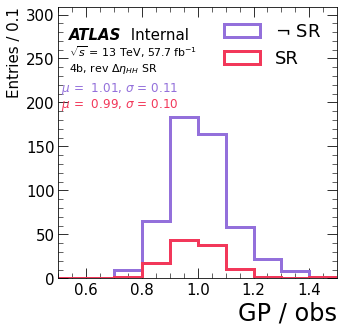

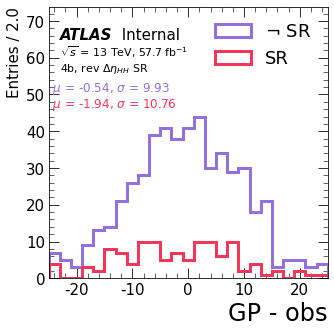

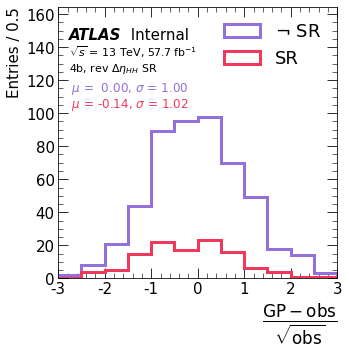

In [130]:
for z,xlabel,tag,r,nb in zip([gp_file['bkgdmodel']/h_obs, gp_file['bkgdmodel']-h_obs, (gp_file['bkgdmodel']-h_obs)/np.sqrt(h_obs)],
                          ['GP / obs','GP - obs', r'$\frac{\mathrm{GP - obs}}{\sqrt{\mathrm{obs}}}$'],
                          ['pred_over_obs','pred_minus_obs','pred_minus_obs_over_sqrt_obs'],
                          [(0.5,1.5),(-25,25),(-3,3)],[10,25,12]):
                                                  
    plot_1d_pulls(z, blind, r, nb, xlabel=xlabel, figName=f'{figDir}/hist_{tag}_{yr}')


**Next:** Marginals in the SR (?)